源码路径：  
https://github.com/dmlc/dgl/tree/master/examples/pytorch/rgcn-hetero

demo目录如下：  
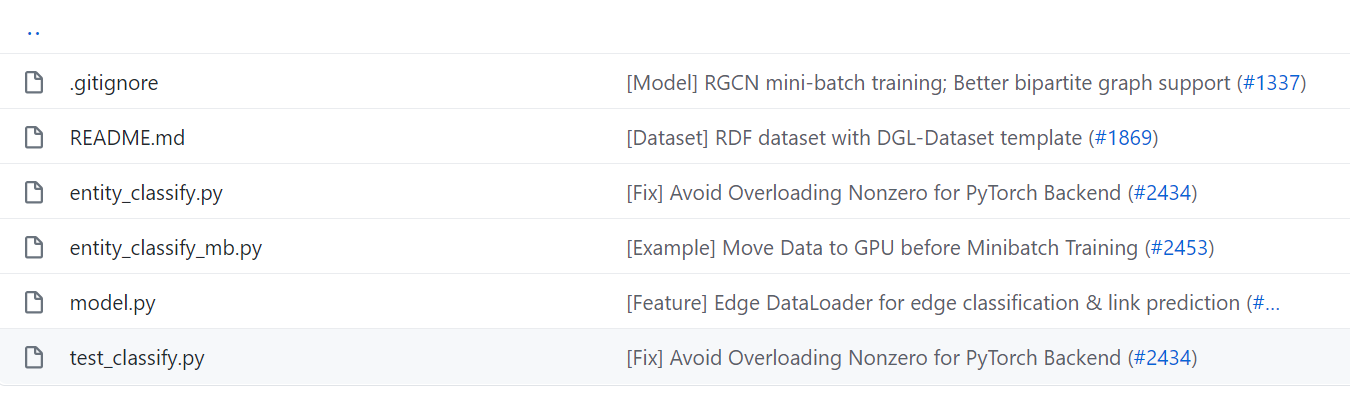

In [ ]:
#先看主程序entity_classify_mb.py
"""Modeling Relational Data with Graph Convolutional Networks
Paper: https://arxiv.org/abs/1703.06103
Reference Code: https://github.com/tkipf/relational-gcn
"""
#常用库
import argparse
import itertools
import numpy as np
import time
import torch as th
import torch.nn.functional as F

#dgl库，内置数据集
import dgl
from dgl.data.rdf import AIFBDataset, MUTAGDataset, BGSDataset, AMDataset

#R-GCN 自定义库
from model import EntityClassify, RelGraphEmbed

#输入节点，根据节点ntype，返回各ntype的embedding，dict类型
def extract_embed(node_embed, input_nodes):
    emb = {}
    for ntype, nid in input_nodes.items():
        nid = input_nodes[ntype]
        emb[ntype] = node_embed[ntype][nid]
    return emb

#模型评估
#loader：dataload，
#node_embed：node feature
#labels：target
#category:Target Category: 以AIFBDataset为例:Personen
#device：cup或gpu_id
def evaluate(model, loader, node_embed, labels, category, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    count = 0
    for input_nodes, seeds, blocks in loader:
        blocks = [blk.to(device) for blk in blocks]
        seeds = seeds[category]
        emb = extract_embed(node_embed, input_nodes)
        emb = {k: e.to(device) for k, e in emb.items()}
        lbl = labels[seeds].to(device)
        logits = model(emb, blocks)[category]
        loss = F.cross_entropy(logits, lbl)
        acc = th.sum(logits.argmax(dim=1) == lbl).item()
        total_loss += loss.item() * len(seeds)
        total_acc += acc
        count += len(seeds)
    return total_loss / count, total_acc / count

def main(args):
    # check cuda
    device = 'cpu'
    use_cuda = args.gpu >= 0 and th.cuda.is_available()
    if use_cuda:
        th.cuda.set_device(args.gpu)
        device = 'cuda:%d' % args.gpu

    # load graph data
    if args.dataset == 'aifb':
        dataset = AIFBDataset()
    elif args.dataset == 'mutag':
        dataset = MUTAGDataset()
    elif args.dataset == 'bgs':
        dataset = BGSDataset()
    elif args.dataset == 'am':
        dataset = AMDataset()
    else:
        raise ValueError()

#     以AIFBDataset为例:
#     AIFB dataset statistics:
#     - Nodes: 7262
#     - Edges: 48810 (including reverse edges)
#     - Target Category: Personen
#     - Number of Classes: 4
#     - Label Split:
#         - Train: 140
#         - Test: 36
    g = dataset[0]
    category = dataset.predict_category
    num_classes = dataset.num_classes
    train_mask = g.nodes[category].data.pop('train_mask')
    test_mask = g.nodes[category].data.pop('test_mask')
    train_idx = th.nonzero(train_mask, as_tuple=False).squeeze()
    test_idx = th.nonzero(test_mask, as_tuple=False).squeeze()
    labels = g.nodes[category].data.pop('labels')

    # split dataset into train, validate, test
    if args.validation:
        val_idx = train_idx[:len(train_idx) // 5]
        train_idx = train_idx[len(train_idx) // 5:]
    else:
        val_idx = train_idx

    # create embeddings
    # create weight embeddings for each node for each relation
    embed_layer = RelGraphEmbed(g, args.n_hidden)

    if not args.data_cpu:
        labels = labels.to(device)
        embed_layer = embed_layer.to(device)

    #node_embed:初始化的weight embeddings
    node_embed = embed_layer()
    # create model
    # args.n_bases：对应Wr中的B，比如W维度：(1000*128)，假设B=10,a(1000*10),Vb(10*128)，则参数量级大大减小
    model = EntityClassify(g,
                           args.n_hidden,
                           num_classes,
                           num_bases=args.n_bases,
                           num_hidden_layers=args.n_layers - 2,
                           dropout=args.dropout,
                           use_self_loop=args.use_self_loop)

    if use_cuda:
        model.cuda()

    #MultiLayerNeighborSampler细节已经在https://zhuanlan.zhihu.com/p/354831060中讲解过
    # train sampler
    sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.n_layers)
    loader = dgl.dataloading.NodeDataLoader(
        g, {category: train_idx}, sampler,
        batch_size=args.batch_size, shuffle=True, num_workers=0)

    # validation sampler
    # we do not use full neighbor to save computation resources
    val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.n_layers)
    val_loader = dgl.dataloading.NodeDataLoader(
        g, {category: val_idx}, val_sampler,
        batch_size=args.batch_size, shuffle=True, num_workers=0)

    # optimizer
    all_params = itertools.chain(model.parameters(), embed_layer.parameters())
    optimizer = th.optim.Adam(all_params, lr=args.lr, weight_decay=args.l2norm)

    # training loop
    print("start training...")
    dur = []
    for epoch in range(args.n_epochs):
        model.train()
        optimizer.zero_grad()
        if epoch > 3:
            t0 = time.time()

        for i, (input_nodes, seeds, blocks) in enumerate(loader):
            blocks = [blk.to(device) for blk in blocks]
            seeds = seeds[category]     # we only predict the nodes with type "category"
            batch_tic = time.time()
            emb = extract_embed(node_embed, input_nodes)
            lbl = labels[seeds]
            if use_cuda:
                emb = {k : e.cuda() for k, e in emb.items()}
                lbl = lbl.cuda()
            logits = model(emb, blocks)[category]
            loss = F.cross_entropy(logits, lbl)
            loss.backward()
            optimizer.step()

            train_acc = th.sum(logits.argmax(dim=1) == lbl).item() / len(seeds)
            print("Epoch {:05d} | Batch {:03d} | Train Acc: {:.4f} | Train Loss: {:.4f} | Time: {:.4f}".
                  format(epoch, i, train_acc, loss.item(), time.time() - batch_tic))

        if epoch > 3:
            dur.append(time.time() - t0)

        val_loss, val_acc = evaluate(model, val_loader, node_embed, labels, category, device)
        print("Epoch {:05d} | Valid Acc: {:.4f} | Valid loss: {:.4f} | Time: {:.4f}".
              format(epoch, val_acc, val_loss, np.average(dur)))
    print()
    #保存model
    if args.model_path is not None:
        th.save(model.state_dict(), args.model_path)

    output = model.inference(
        g, args.batch_size, 'cuda' if use_cuda else 'cpu', 0, node_embed)
    test_pred = output[category][test_idx]
    test_labels = labels[test_idx]
    test_acc = (test_pred.argmax(1) == test_labels).float().mean()
    print("Test Acc: {:.4f}".format(test_acc))
    print()

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='RGCN')
    parser.add_argument("--dropout", type=float, default=0,
            help="dropout probability")
    parser.add_argument("--n-hidden", type=int, default=16,
            help="number of hidden units")
    parser.add_argument("--gpu", type=int, default=-1,
            help="gpu")
    parser.add_argument("--lr", type=float, default=1e-2,
            help="learning rate")
    parser.add_argument("--n-bases", type=int, default=-1,
            help="number of filter weight matrices, default: -1 [use all]")
    parser.add_argument("--n-layers", type=int, default=2,
            help="number of propagation rounds")
    parser.add_argument("-e", "--n-epochs", type=int, default=20,
            help="number of training epochs")
    parser.add_argument("-d", "--dataset", type=str, required=True,
            help="dataset to use")
    parser.add_argument("--model_path", type=str, default=None,
            help='path for save the model')
    parser.add_argument("--l2norm", type=float, default=0,
            help="l2 norm coef")
    parser.add_argument("--use-self-loop", default=False, action='store_true',
            help="include self feature as a special relation")
    parser.add_argument("--batch-size", type=int, default=100,
            help="Mini-batch size. If -1, use full graph training.")
    parser.add_argument("--fanout", type=int, default=4,
            help="Fan-out of neighbor sampling.")
    parser.add_argument('--data-cpu', action='store_true',
            help="By default the script puts all node features and labels "
                 "on GPU when using it to save time for data copy. This may "
                 "be undesired if they cannot fit in GPU memory at once. "
                 "This flag disables that.")
    fp = parser.add_mutually_exclusive_group(required=False)
    fp.add_argument('--validation', dest='validation', action='store_true')
    fp.add_argument('--testing', dest='validation', action='store_false')
    parser.set_defaults(validation=True)

    args = parser.parse_args()
    print(args)
    main(args)

In [ ]:
#接着来分析下model.py
"""RGCN layer implementation"""
from collections import defaultdict

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import tqdm

class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.

    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 num_bases,
                 *,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop

        #https://docs.dgl.ai/api/python/nn.pytorch.html?highlight=heterographconv#dgl.nn.pytorch.HeteroGraphConv
#         示例：
#         import dgl.nn.pytorch as dglnn
#         conv = dglnn.HeteroGraphConv({
#         'follows' : dglnn.GraphConv(...),
#         'plays' : dglnn.GraphConv(...),
#         'sells' : dglnn.SAGEConv(...)},
#         aggregate='sum')
        
        self.conv = dglnn.HeteroGraphConv({
                rel : dglnn.GraphConv(in_feat, out_feat, norm='right', weight=False, bias=False)
                for rel in rel_names
            })

        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                #dglnn.WeightBasis: Wr的实现
                self.basis = dglnn.WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        """Forward computation

        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.

        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

class RelGraphEmbed(nn.Module):
    r"""Embedding layer for featureless heterograph."""
    def __init__(self,
                 g,
                 embed_size,
                 embed_name='embed',
                 activation=None,
                 dropout=0.0):
        super(RelGraphEmbed, self).__init__()
        self.g = g
        self.embed_size = embed_size
        self.embed_name = embed_name
        self.activation = activation
        self.dropout = nn.Dropout(dropout)

        # create weight embeddings for each node for each relation
        self.embeds = nn.ParameterDict()
        for ntype in g.ntypes:
            embed = nn.Parameter(th.Tensor(g.number_of_nodes(ntype), self.embed_size))
            nn.init.xavier_uniform_(embed, gain=nn.init.calculate_gain('relu'))
            self.embeds[ntype] = embed

    def forward(self, block=None):
        """Forward computation

        Parameters
        ----------
        block : DGLHeteroGraph, optional
            If not specified, directly return the full graph with embeddings stored in
            :attr:`embed_name`. Otherwise, extract and store the embeddings to the block
            graph and return.

        Returns
        -------
        DGLHeteroGraph
            The block graph fed with embeddings.
        """
        return self.embeds

class EntityClassify(nn.Module):
    def __init__(self,
                 g,
                 h_dim, out_dim,
                 num_bases,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(EntityClassify, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
        self.rel_names.sort()
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop

        #因为节点没有h，所以生成h_embed
        self.embed_layer = RelGraphEmbed(g, self.h_dim)
        self.layers = nn.ModuleList()
        # i2h
        self.layers.append(RelGraphConvLayer(
            self.h_dim, self.h_dim, self.rel_names,
            self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
            dropout=self.dropout, weight=False))
        # h2h
        for i in range(self.num_hidden_layers):
            self.layers.append(RelGraphConvLayer(
                self.h_dim, self.h_dim, self.rel_names,
                self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                dropout=self.dropout))
        # h2o
        self.layers.append(RelGraphConvLayer(
            self.h_dim, self.out_dim, self.rel_names,
            self.num_bases, activation=None,
            self_loop=self.use_self_loop))

    def forward(self, h=None, blocks=None):
        if h is None:
            # full graph training
            h = self.embed_layer()
        if blocks is None:
            # full graph training
            for layer in self.layers:
                h = layer(self.g, h)
        else:
            # minibatch training
            for layer, block in zip(self.layers, blocks):
                h = layer(block, h)
        return h

    def inference(self, g, batch_size, device, num_workers, x=None):
        """Minibatch inference of final representation over all node types.

        ***NOTE***
        For node classification, the model is trained to predict on only one node type's
        label.  Therefore, only that type's final representation is meaningful.
        """

        if x is None:
            x = self.embed_layer()

        for l, layer in enumerate(self.layers):
            y = {
                k: th.zeros(
                    g.number_of_nodes(k),
                    self.h_dim if l != len(self.layers) - 1 else self.out_dim)
                for k in g.ntypes}

            #each node takes messages from all neighbors
            sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1)
            dataloader = dgl.dataloading.NodeDataLoader(
                g,
                {k: th.arange(g.number_of_nodes(k)) for k in g.ntypes},
                sampler,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
                num_workers=num_workers)

            for input_nodes, output_nodes, blocks in tqdm.tqdm(dataloader):
                block = blocks[0].to(device)

                h = {k: x[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
                h = layer(block, h)

                for k in h.keys():
                    y[k][output_nodes[k]] = h[k].cpu()

            x = y
        return y

In [ ]:
#接着来分析test_classify.py
"""Infering Relational Data with Graph Convolutional Networks
"""
import argparse
import torch as th
from functools import partial
import torch.nn.functional as F

from dgl.data.rdf import AIFB, MUTAG, BGS, AM
from entity_classify import EntityClassify

def main(args):
    # load graph data
    if args.dataset == 'aifb':
        dataset = AIFBDataset()
    elif args.dataset == 'mutag':
        dataset = MUTAGDataset()
    elif args.dataset == 'bgs':
        dataset = BGSDataset()
    elif args.dataset == 'am':
        dataset = AMDataset()
    else:
        raise ValueError()

    g = dataset[0]
    category = dataset.predict_category
    num_classes = dataset.num_classes
    test_mask = g.nodes[category].data.pop('test_mask')
    test_idx = th.nonzero(test_mask, as_tuple=False).squeeze()
    labels = g.nodes[category].data.pop('labels')

    # check cuda
    use_cuda = args.gpu >= 0 and th.cuda.is_available()
    if use_cuda:
        th.cuda.set_device(args.gpu)
        labels = labels.cuda()
        test_idx = test_idx.cuda()
        g = g.to('cuda:%d' % args.gpu)

    # create model
    model = EntityClassify(g,
                           args.n_hidden,
                           num_classes,
                           num_bases=args.n_bases,
                           num_hidden_layers=args.n_layers - 2,
                           use_self_loop=args.use_self_loop)
    #加载模型，用于预测
    model.load_state_dict(th.load(args.model_path))
    if use_cuda:
        model.cuda()

    print("start testing...")
    model.eval()
    logits = model.forward()[category]
    test_loss = F.cross_entropy(logits[test_idx], labels[test_idx])
    test_acc = th.sum(logits[test_idx].argmax(dim=1) == labels[test_idx]).item() / len(test_idx)
    print("Test Acc: {:.4f} | Test loss: {:.4f}".format(test_acc, test_loss.item()))
    print()

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='RGCN')
    parser.add_argument("--n-hidden", type=int, default=16,
            help="number of hidden units")
    parser.add_argument("--gpu", type=int, default=-1,
            help="gpu")
    parser.add_argument("--lr", type=float, default=1e-2,
            help="learning rate")
    parser.add_argument("--n-bases", type=int, default=-1,
            help="number of filter weight matrices, default: -1 [use all]")
    parser.add_argument("--n-layers", type=int, default=2,
            help="number of propagation rounds")
    parser.add_argument("-d", "--dataset", type=str, required=True,
            help="dataset to use")
    parser.add_argument("--model_path", type=str,
            help='path of the model to load from')
    parser.add_argument("--use-self-loop", default=False, action='store_true',
            help="include self feature as a special relation")

    args = parser.parse_args()
    print(args)
    main(args)

In [2]:
from collections import defaultdict

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import tqdm

??dglnn.WeightBasis